### Description:
Testing Environment for removing trees from a panoramic image

### Functions:

In [6]:
from diffusers.utils import load_image, make_image_grid
import torch
from diffusers import AutoPipelineForInpainting



def remove_trees(path_to_image, path_to_tree_mask, path_to_building_mask, path_to_sky_mask):
    if not torch.cuda.is_available():
        print("Please ensure cuda is available before running.")
        return
    
    
    
    pipeline = AutoPipelineForInpainting.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16, variant="fp16"
    )
    pipeline.enable_model_cpu_offload()
    
    init_image = load_image(path_to_image)
    image_width, image_height = init_image.size
    mask_image = load_image(path_to_tree_mask)
    
  
    prompt = "photoralistic buildings and sky highly detailed, 8k"
    # prompt = (
    # "Prioritize Seamless photorealistic sky continuation, no artifacts, highly detailed, 8k"

    # )

    print("Prompt: ", prompt)
    print("create generator")
    generator = torch.Generator("cuda").manual_seed(92)
    print("Starting inpainting")
    image = pipeline(prompt=prompt , image=init_image, mask_image=mask_image, generator=generator).images[0]
    print(" Impainting done, resizing image")
    image = image.resize((image_width, image_height))
    return image

### Main:

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2


def plot_image(image, title="None"):
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis("off")  # Hide axes for cleaner visualization
    plt.show()

def inpaint_with_masks(tree_mask, sky_mask, building_mask):
    # Convert the masks to the right format (uint8, 0 and 255 values)
    tree_mask = np.uint8(tree_mask * 255)
    sky_mask = np.uint8(sky_mask * 255)
    building_mask = np.uint8(building_mask * 255)
    
    # Combine the sky_mask and building_mask to create a mask for inpainting
    combined_mask = np.maximum(sky_mask, building_mask)
    
    # Inpainting: Inpaint areas of tree_mask where it's 0 (missing) using combined mask
    inpainted_tree_mask = cv2.inpaint(tree_mask, combined_mask, 3, cv2.INPAINT_TELEA)
    
    # Return the inpainted mask (normalized to 0-1 range if needed)
    return inpainted_tree_mask / 255.0

In [38]:

from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from diffusers import AutoPipelineForInpainting

import numpy as np



def store_remove_trees_panoramic(panoramic_segmentation_path, panoramic_img_path):
    print("[store_remove_trees_panoramic] starting...")
    panoramic_img = Image.open(panoramic_img_path)
    segmentation_map = Image.open(panoramic_segmentation_path)
    
    segmentation_map_array = np.array(segmentation_map)

    plot_image(panoramic_img, title="Panoramic Image")
    plot_image(segmentation_map_array, title="Original Panoramic Segmentation Image")

    tree_mask = (segmentation_map_array == 8).astype(np.uint8) * 255
    building_mask = (segmentation_map_array == 2).astype(np.uint8) * 255
    sky_mask = (segmentation_map_array == 10).astype(np.uint8) * 255

    plot_image(tree_mask, title="Tree Mask")
    plot_image(building_mask, title="Building Mask")
    plot_image(sky_mask, title="Sky Mask")

    # Create the combined mask: sky or building areas
    combined_mask = np.maximum(sky_mask, building_mask)
    plot_image(combined_mask, title="Combined Mask")

    # Inpaint the tree mask using the combined mask (where 0 in tree_mask will be filled)
    inpainted_tree_mask = cv2.inpaint(tree_mask, combined_mask, 3, cv2.INPAINT_TELEA)

    # Normalize the result to 0-1 if needed
    inpainted_tree_mask = inpainted_tree_mask / 255.0

    # Plot the inpainted tree mask
    plot_image(inpainted_tree_mask, title="Inpainted Tree Mask")

    # Replace the tree class (8) in the original segmentation map with the inpainted result
    inpainted_tree_mask = (inpainted_tree_mask * 255).astype(np.uint8)  # Convert back to 0-255 range

    # Create a copy of the original segmentation map to modify
    updated_segmentation_map_array = np.copy(segmentation_map_array)

    # Where the tree mask is present, replace the segmentation value with sky or building (whichever is closest)
    updated_segmentation_map_array[tree_mask == 255] = 10  # Assign sky class (10) where trees were

    # Plot the updated segmentation map (without tree class)
    plot_image(updated_segmentation_map_array, title="Updated Segmentation Map (without Tree Class)")


def get_remove_trees_panoramic(image_path):
    """
        image_path: path to original panoramic image
    """

    # -W-u6oxxcZfhXSxvCHtomQ
    # 2gzizC8uRTlcEU-9GuZhmQ
    # image_path = "data/panoramic_imgs/-W-u6oxxcZfhXSxvCHtomQ.jpg" 
    mask_path = 'tree_mask.jpg'
    print("[get_remove_trees_panoramic] starting...")

    
    segmentation_map = Image.open(image_path)

    feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
    model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
    print("Feature and model loaded")
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits

    print("about to convert logits to class predictions")
    # convert logits to class predictions
    predicted_class = torch.argmax(logits, dim=1)  # shape (batch_size, height/4, width/4)

    # upsample to match input image size
    predicted_class = torch.nn.functional.interpolate(
        predicted_class.unsqueeze(1).float(),  # Add channel dimension
        size=image.size[::-1],  # Match input image dimensions (height, width)
        mode="nearest"
    ).squeeze(1).to(torch.int32)

    print("generating segmentation map...")
    # visualize
    segmentation_map = predicted_class[0].cpu().numpy()

    
    
    tree_mask = (segmentation_map == 8).astype(np.uint8) * 255
    building_mask = (segmentation_map == 2).astype(np.uint8) * 255 
    sky_mask = (segmentation_map == 10).astype(np.uint8) * 255
    
    plot_image(tree_mask, title="Tree Mask")
    plot_image(building_mask, title="Building Mask")
    plot_image(sky_mask, title="Sky Mask")

    im = Image.fromarray(tree_mask)

    im.save('tree_mask.jpg')
    print('saved mask image')
    
    print('inpainting image... this may take a minute')
    # inpainted_img = remove_trees(image_path, mask_path,"", "")
    # inpainted_img = remove_trees(image_path)
    inpainted_img = inpaint_with_masks(tree_mask)
    inpainted_img.save('inpainted_img.jpg')
    
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    # Original image
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    # Mask
    ax[1].imshow(tree_mask, cmap='gray')
    ax[1].set_title("Tree Mask")
    ax[1].axis("off")

    # Inpainted image
    ax[2].imshow(inpainted_img)
    ax[2].set_title("Inpainted Image")
    ax[2].axis("off")
    
    plt.tight_layout()
    plt.show()




[store_remove_trees_panoramic] starting...


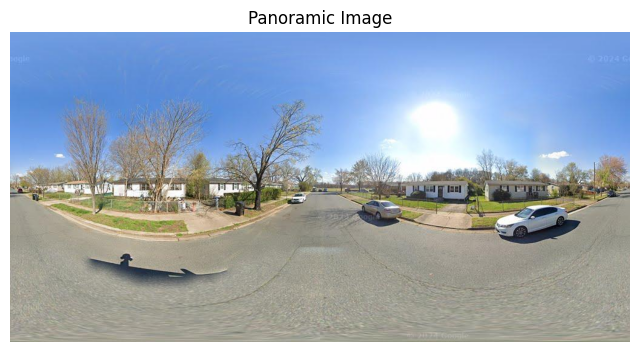

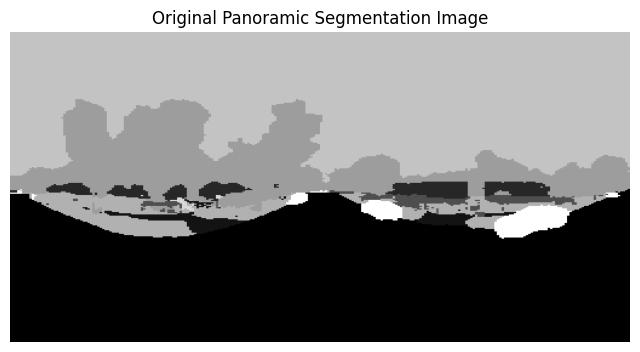

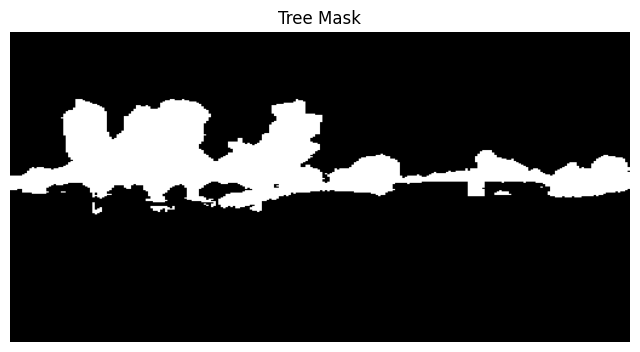

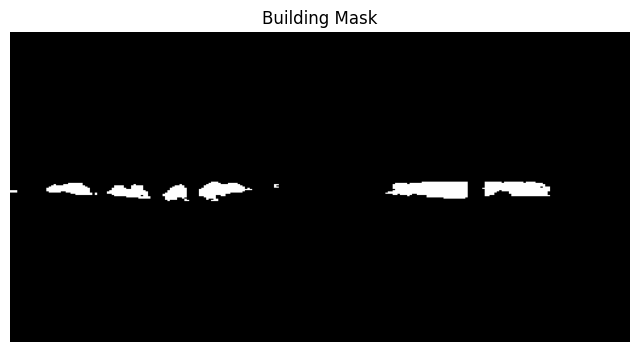

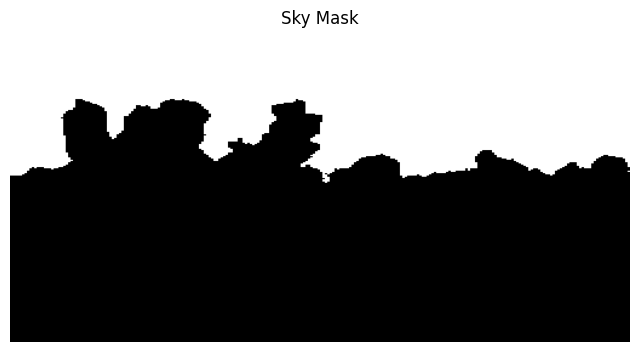

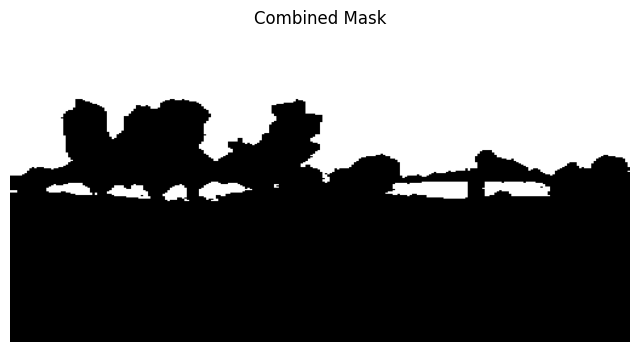

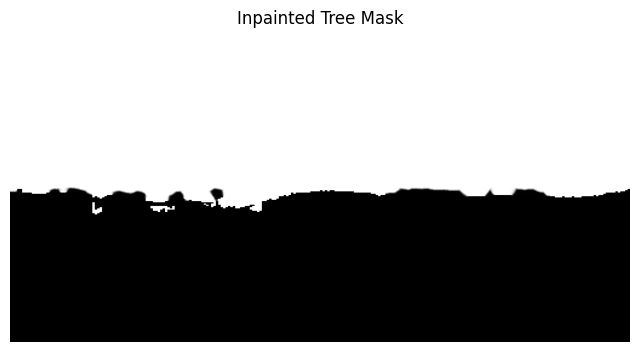

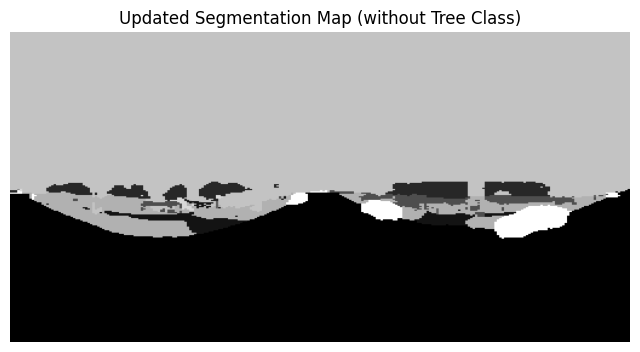

In [40]:
# pano_id = "_c4zL-Y8W8SmvornfJ6E0g"
# pano_id = "ZxuoxWAGyGV7KsJWuaGoug"
pano_id = "zWhEC282DmF04sRvzNV2MQ"
panoramic_img_path = f"../data/fredericksburg/fredericksburg_panoramic_imgs/panoramic_imgs/{pano_id}.jpg"
store_remove_trees_panoramic(f"../data/fredericksburg/fredericksburg_panoramic_imgs/panoramic_segmentation_maps/{pano_id}.png", panoramic_img_path)